In [1]:
# GENERAL THINGS FOR COMPUTING AND PLOTTING
import pandas as pd
import numpy as np
import os, sys, time
from datetime import datetime
from datetime import timedelta
import scipy as sp
import pingouin as pg
from IPython import embed as shell

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", context="talk")

# ibl specific things
import datajoint as dj
from ibl_pipeline import reference, subject, action, acquisition, data, behavior
from ibl_pipeline.analyses import behavior as behavioral_analyses

# set path for saving figures
figpath = 'figures' # put in the same folder, but add to .gitignore for now

Connecting anneurai@datajoint.internationalbrainlab.org:3306


In [2]:
## GET WEIGHT AND WATER DATA FOR ALL MICE THAT ARE IN THE BEHAVIORAL STANDARDIZATION PREPRINT
# subj = subject.Subject * subject.SubjectLab & \
#         (subject.SubjectProject & 'subject_project = "ibl_neuropixel_brainwide_01"') 
subj_query = (subject.Subject * subject.SubjectLab * reference.Lab * subject.SubjectProject
              & 'subject_project = "ibl_neuropixel_brainwide_01"').aggr(
    (acquisition.Session * behavioral_analyses.SessionTrainingStatus())
    & 'training_status="trained_1a" OR training_status="trained_1b"',
    'subject_nickname', 'sex', 'subject_birth_date', 
    date_trained='min(date(session_start_time))')
subj = (subj_query & 'date_trained <= "2020-03-23"')

# average watering and weight per session date
weight_with_date = subj * action.Weighing.proj('weight', session_date='DATE(weighing_time)')
weight_date = (dj.U('subject_uuid', 'session_date') & weight_with_date)
avg_weight_date = weight_date.aggr(weight_with_date, avg_weight='AVG(weight)')
water_with_date = action.WaterAdministration.proj('watertype_name', 'water_administered', 'adlib',
                                                  session_date='DATE(administration_time)')
water_date = (dj.U('subject_uuid', 'session_date') & water_with_date)
total_water_date = water_date.aggr(water_with_date, total_water='SUM(water_administered)', 
                                   watertype="GROUP_CONCAT(DISTINCT watertype_name SEPARATOR '; ')", 
                                   adlib='MAX(adlib)')\

# combine all
b = subj  * avg_weight_date * total_water_date
b = b.proj('subject_nickname', 'subject_birth_date','sex', 'lab_name', 'avg_weight', 'total_water', 'watertype')
df = pd.DataFrame(b.fetch(as_dict=True))

# errors in the database; throw away crazy weights
df = df[~(df['avg_weight'] > 80)] 
df = df[~(df['avg_weight'] < 10)] 

In [3]:
# FOR EACH LAB, WHAT'S THE WEEKEND WATER REGIME?
lab_watermap = {}
for name, group in df.groupby(['lab_name']):
    #print(name)
    #print(group.watertype.unique())
    matching = [s for s in group.watertype if "Citric" in s]
    if not len(matching) == 0:
        lab_watermap.update({name:'CA'})
    else:
        lab_watermap.update({name:'restr'})

df['weekend_water_regime'] = df['lab_name'].map(lab_watermap)
df.weekend_water_regime.unique()

array(['restr', 'CA'], dtype=object)

In [4]:
## ADD INFO ABOUT WATER RESTRICTIONS PER MOUSE
weight_normalized = pd.DataFrame([])
for index, sjdatgr in df.groupby(['subject_nickname']):
    sjdat = sjdatgr.copy() # avoid copy warnings
    
    # add normalized weights (from mean per sj) and days from first weighing
    # sjdat['norm_weight'] = sjdat['avg_weight'] / sjdat['avg_weight'].mean()
    sjdat['days_weight'] = sjdat['session_date'] - sjdat['session_date'].min()
    
    # FOR EACH ANIMAL, ADD THEIR WATER RESTRICTION DATES AND REFERENCE WEIGHT
    subj_q = (subject.Subject & 'subject_nickname="%s"'%index) \
                & ( subject.SubjectLab & 'lab_name="%s"'%sjdat.lab_name.unique().item())
    restrictions = (action.WaterRestriction & subj_q).proj(
        'reference_weight',
        restriction_start_date='DATE(restriction_start_time)', 
        restriction_end_date='DATE(restriction_end_time)')
    restrictions = restrictions.fetch(format='frame').reset_index()
    
    # MAKE A NEW COLUMN THAT INDICATES THE START AND END OF WATER RESTRICTION
    if len(restrictions) > 0:
        
        # TAKE ONLY THE FIRST WATER RESTRICTION
        if len(restrictions) > 1:
            restrictions = restrictions.sort_values(by=['restriction_start_date']).head(n=1)
            
        if any(restrictions.restriction_end_date.isnull()):
            # print(subj_q.fetch1('subject_nickname'))
            #restrictions.restriction_end_date[0] = datetime.strptime('23032020', "%d%m%Y").date()
            print('%s''s first WR has no end date'%subj_q.fetch1('subject_nickname'))
          
        else:
            
            # ensure we add a weight on the day that was logged as start of WR
            sjdat = sjdat.append({'subject_uuid':sjdat.subject_uuid.unique().item(),
                          'subject_nickname':sjdat.subject_nickname.unique().item(),
                          'sex':sjdat.sex.unique().item(),
                          'subject_birth_date':sjdat.subject_birth_date.unique().item(),
                          'weekend_water_regime':sjdat.weekend_water_regime.unique().item(),
                          'watertype':'water',
                          'lab_name':sjdat.lab_name.unique().item(),
                          'subject_project':sjdat.subject_project.unique().item(),
                          'session_date':restrictions.restriction_start_date.item(),
                          'avg_weight':restrictions.reference_weight.item()}, ignore_index=True)

            # look at weight curves as a function the animal's reference weight
            sjdat['norm_weight'] = sjdat['avg_weight'] / restrictions.reference_weight.item()

            # new date axis, linearly spaced
            restr_dates_linear = pd.DataFrame(pd.date_range(restrictions.restriction_start_date.item(), 
                                            restrictions.restriction_end_date.item()
                                                        )).reset_index().rename(columns={'index': 'day_restr', 0: 'session_date'})
            # ensure these are the same format before merge
            restr_dates_linear['session_date'] = restr_dates_linear['session_date'].dt.date
            # sjdat['session_date'] = sjdat['session_date'].dt.date
            sjdat = sjdat.merge(restr_dates_linear.set_index('session_date'), on=['session_date'])
            weight_normalized = weight_normalized.append(sjdat)

    else:
        print('%s has no WRs logged'%subj_q.fetch1('subject_nickname'))

# make into a new dataframe
df = weight_normalized.copy()

CSH_ZAD_002s first WR has no end date
CSH_ZAD_005s first WR has no end date
CSH_ZAD_006s first WR has no end date
CSH_ZAD_007s first WR has no end date
CSH_ZAD_010s first WR has no end date
CSH_ZAD_011s first WR has no end date
CSH_ZAD_017s first WR has no end date
CSH_ZAD_022s first WR has no end date
DY_008s first WR has no end date
DY_009s first WR has no end date
DY_010s first WR has no end date
DY_011s first WR has no end date
DY_013s first WR has no end date
DY_014s first WR has no end date
DY_015s first WR has no end date
IBL_001s first WR has no end date
IBL_002s first WR has no end date
ibl_witten_12s first WR has no end date
ibl_witten_13s first WR has no end date
ibl_witten_14s first WR has no end date


In [5]:
# compute age range
df['session_age'] = (df.session_date - df.subject_birth_date)

## ADD SOME MORE USEFUL INFO - group by week, from Saturday to Friday
df['session_date'] = pd.to_datetime(df.session_date)
df['week_number']  = df['session_date'].dt.week
df['weekday_name'] = df['session_date'].dt.day_name()
#df['days_weight']  = df['days_weight'].dt.days

df.groupby(['days_weight'])['session_age'].describe()

,count,mean,std,min,25%,50%,75%,max
days_weight,,,,,,,,
0 days,118,85 days 22:34:34.576271,14 days 13:17:39.804879,56 days,78 days,85 days 00:00:00,91 days,149 days
1 days,112,86 days 16:42:51.428571,14 days 17:19:36.571504,57 days,79 days,86 days 00:00:00,92 days,150 days
2 days,109,87 days 03:31:22.568807,14 days 16:54:19.028508,58 days,80 days,87 days 00:00:00,92 days,151 days
3 days,69,92 days 19:28:41.739130,15 days 00:04:37.412764,74 days,88 days,91 days 00:00:00,95 days,152 days
4 days,58,93 days 16:08:16.551724,15 days 17:44:55.680850,75 days,88 days,90 days 12:00:00,94 days,153 days
...,...,...,...,...,...,...,...,...
174 days,1,272 days 00:00:00,NaT,272 days,272 days,272 days 00:00:00,272 days,272 days
175 days,1,273 days 00:00:00,NaT,273 days,273 days,273 days 00:00:00,273 days,273 days
176 days,1,274 days 00:00:00,NaT,274 days,274 days,274 days 00:00:00,274 days,274 days


 ## part 2: learning curves

In [6]:
b = (behavioral_analyses.BehavioralSummaryByDate * subj)
behav = b.fetch(order_by='subject_nickname, training_day',
                format='frame').reset_index()
behav['weekend_water_regime'] = behav['lab_name'].map(lab_watermap)
behav.n_trials_date = behav.n_trials_date.astype(int) # make sure this can be plotted

# make sure each mouse starts at 0
for index, group in behav.groupby(['lab_name', 'subject_nickname']):
    behav['training_day'][behav.index.isin(
        group.index)] = group['training_day'] - group['training_day'].min()
behav['performance_easy'] = behav.performance_easy * 100

behav.groupby(['weekend_water_regime'])['lab_name', 'subject_nickname'].nunique()

/anaconda3/envs/iblenv/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/anaconda3/envs/iblenv/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  del sys.path[0]


,lab_name,subject_nickname
weekend_water_regime,,
CA,4,82
restr,5,58


In [7]:
behav.groupby(['weekend_water_regime', 'lab_name'])['lab_name'].unique()

weekend_water_regime  lab_name      
CA                    angelakilab          [angelakilab]
                      churchlandlab      [churchlandlab]
                      mainenlab              [mainenlab]
                      zadorlab                [zadorlab]
restr                 cortexlab              [cortexlab]
                      danlab                    [danlab]
                      hoferlab                [hoferlab]
                      mrsicflogellab    [mrsicflogellab]
                      wittenlab              [wittenlab]
Name: lab_name, dtype: object

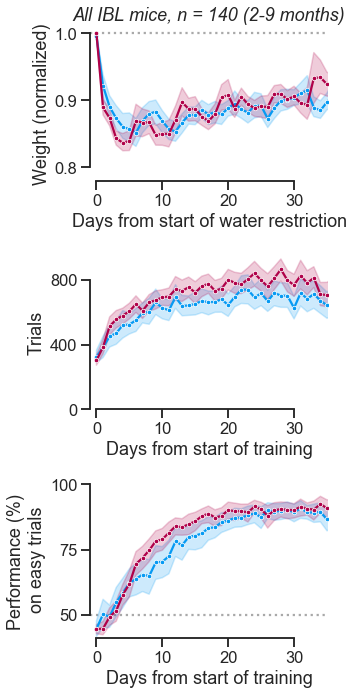

In [20]:
## NOW PLOT
condition_order = [ "restr", "CA"]
palette = sns.xkcd_palette(['azure', 'raspberry'])
f, ax = plt.subplots(ncols=1, nrows=3, figsize=[5, 10])

# 1. weight
sns.lineplot(data=df, x='day_restr', y='norm_weight', hue='weekend_water_regime', 
                 palette=palette, hue_order=condition_order, ax=ax[0], legend=False, 
                err_style='band', marker='.')
ax[0].axhline(y=1, color='darkgrey', linestyle=':', zorder=-100)
ax[0].set(xlim=[-1, 35.2], ylim=[0.78, 1.01], yticks=[0.8, 0.9, 1],
          xlabel='Days from start of water restriction', ylabel="Weight (normalized)")

# 2. trials
sns.lineplot(data=behav, x='training_day', y='n_trials_date', hue='weekend_water_regime', 
                 palette=palette, hue_order=condition_order, ax=ax[1], legend=False, 
                err_style='band', marker='.')            
ax[1].set(xlim=ax[0].get_xlim(), yticks=[0, 400, 800], ylim=[0, 950],
          xlabel='Days from start of training', ylabel="Trials")

# 3. performance
sns.lineplot(data=behav, x='training_day', y='performance_easy', hue='weekend_water_regime', 
                 palette=palette, hue_order=condition_order, ax=ax[2], legend=False, 
                err_style='band', marker='.')    
ax[2].axhline(y=50, color='darkgrey', linestyle=':', zorder=-100)
ax[2].set(xlim=ax[0].get_xlim(), ylim=[41, 100], yticks=[50, 75, 100],
          xlabel='Days from start of training', ylabel="Performance (%)\n on easy trials")

ax[0].set_title('All IBL mice, n = %d (2-9 months)'%behav.subject_uuid.nunique(), fontsize=18, fontstyle='italic')
sns.despine(trim=True)
#f.tight_layout(rect=[0, 0.03, 1, 0.95])
f.tight_layout()
f.savefig(os.path.join(figpath, "ibl_learningcurves.pdf"))